In [1]:
%load_ext pycodestyle_magic
%load_ext jupyternotify
%load_ext autoreload
%autoreload 2
%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
import sys
sys.path.append('../')

In [160]:
from utils.data import CIFAR10_dataset
from utils.misc import (
    show_random_images,
    get_device,
    set_seed,
    is_cuda,
    show_model_summary,
    show_img_grid,
    show_random_images_for_each_class,
)
from utils.model import Net
from utils.training import train
from utils.testing import test

In [4]:
set_seed()
cuda = is_cuda()
device = get_device()

[INFO] seed set 1
[INFO] Cuda Avaliable :  False
[INFO] device :  cpu


In [74]:
train_loader = CIFAR10_dataset(
    train=True, cuda=cuda, normalized=True
).get_loader()
test_loader = CIFAR10_dataset(
    train=False, cuda=cuda
).get_loader()

Files already downloaded and verified

        [INFO] train dataset of size 50000 loaded...
        
Files already downloaded and verified

        [INFO] test dataset of size 10000 loaded...
        


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


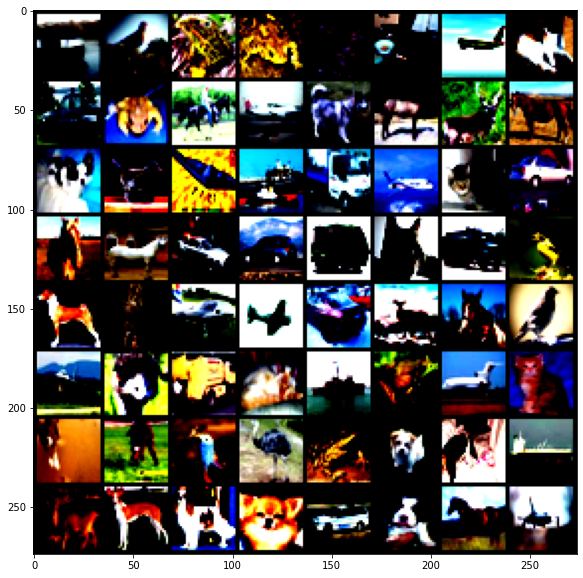

In [122]:
show_random_images(train_loader)

## Calculate mean and std of dataset

In [163]:
train_data = CIFAR10_dataset(
    train=True, cuda=cuda, normalized=False
).get_data()
test_data = CIFAR10_dataset(
    train=False, cuda=cuda, normalized=False
).get_data()

Files already downloaded and verified
Files already downloaded and verified


In [84]:
## mean of data
[
    round(train_data.data[..., n].mean() / 255, 3)
    for n in range(train_data.data.shape[-1])
]

[0.491, 0.482, 0.447]

In [85]:
## mean of data
[
    round(train_data.data[..., n].std() / 255, 3)
    for n in range(train_data.data.shape[-1])
]

[0.247, 0.243, 0.262]

## look at data

In [143]:
from collections import Counter
import matplotlib.pyplot as plt
import random
import numpy as np
import torchvision
import torch

In [87]:
train_data.data.shape

(50000, 32, 32, 3)

In [92]:
len(train_data.targets)

50000

In [165]:
## 1000 images per class for test, and 5000 images per class for train

<BarContainer object of 10 artists>

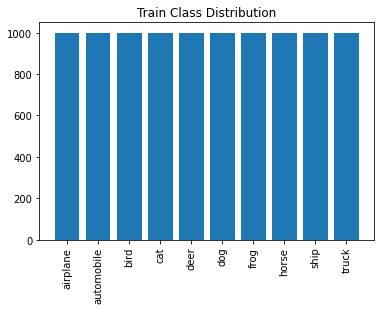

In [164]:
plt.xticks(rotation='vertical')
plt.title("Train Class Distribution")
plt.bar(train_data.classes, Counter(train_data.targets).values())

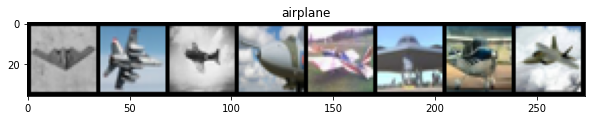

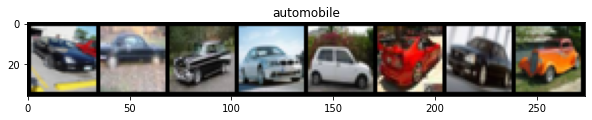

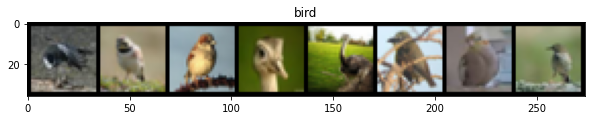

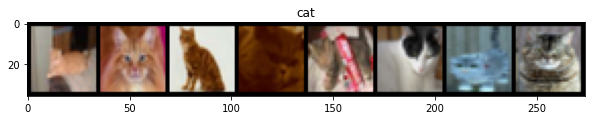

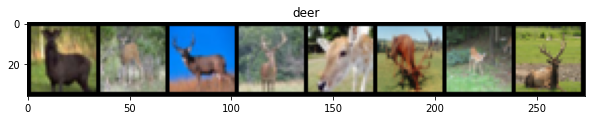

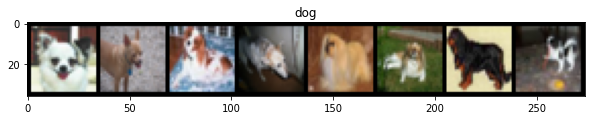

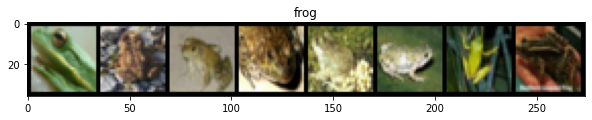

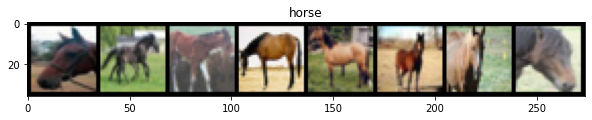

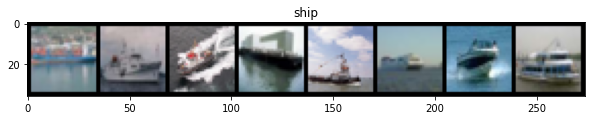

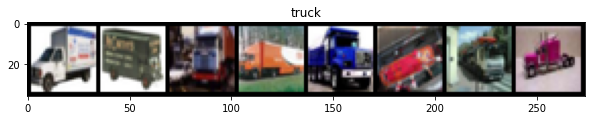

In [162]:
show_random_images_for_each_class(train_data, num_images_per_class=8)

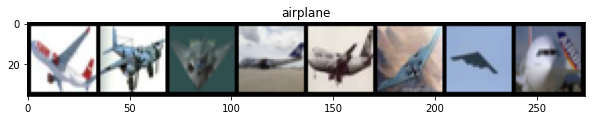

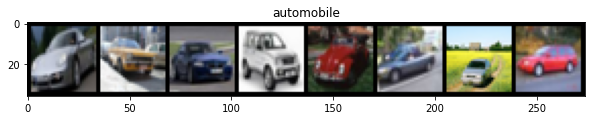

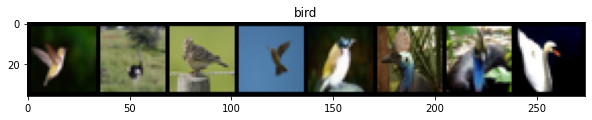

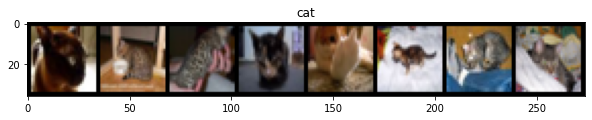

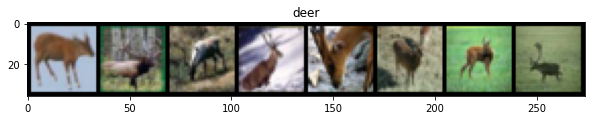

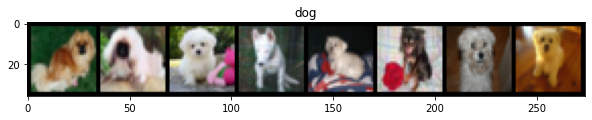

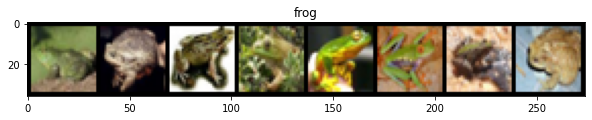

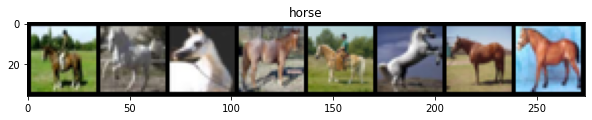

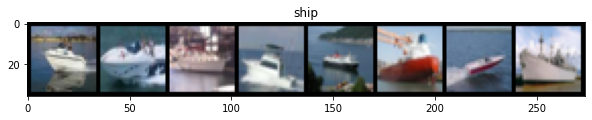

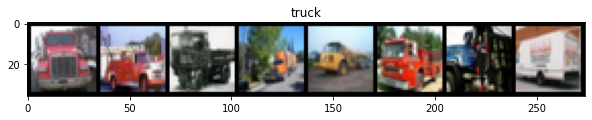

In [167]:
show_random_images_for_each_class(test_data, num_images_per_class=8)

In [7]:
net = Net(dropout_value=0.05, BN=True).to(device)
show_model_summary(net)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              54
              ReLU-2            [-1, 6, 26, 26]               0
           Dropout-3            [-1, 6, 26, 26]               0
       BatchNorm2d-4            [-1, 6, 26, 26]              12
            Conv2d-5           [-1, 12, 24, 24]             648
              ReLU-6           [-1, 12, 24, 24]               0
           Dropout-7           [-1, 12, 24, 24]               0
       BatchNorm2d-8           [-1, 12, 24, 24]              24
            Conv2d-9            [-1, 7, 24, 24]              84
        MaxPool2d-10            [-1, 7, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,008
             ReLU-12           [-1, 16, 10, 10]               0
          Dropout-13           [-1, 16, 10, 10]               0
      BatchNorm2d-14           [-1, 16,

In [19]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import numpy as np

In [40]:
L1 = False
L2 = False
weight_decay = 1e-5 if L2 else 0

optimizer = optim.SGD(
    net.parameters(), 
    lr=0.020, momentum=0.9, 
    weight_decay=weight_decay
)
lr_scheduler = ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, 
    patience=2, min_lr=0.001, verbose=True
)

In [46]:
train_loss_batch, train_acc_batch = train(
    net, device, 
    train_loader, 
    optimizer, 
    lr_scheduler,
    L1=L1
)
train_acc = np.mean(train_acc_batch)
train_loss = np.mean(train_loss_batch)

  0%|          | 0/938 [00:00<?, ?it/s]

In [49]:
test_loss, test_acc = test(
    net, device, 
    test_loader,
    lr_scheduler
)


Test set: Average loss: 0.0628, Accuracy: 9794/10000 (97.94%)

